In [1]:
from ultralytics import YOLO
from result_functions import interpret_result, keypart2index, keypoint2index
import cv2

import zone_functions
import result_functions
import Models
import Hand_Controls

from PIL import Image

import torch
import numpy as np
from matplotlib import pyplot as plt, patches

In [2]:
model = YOLO("yolov8n-pose.pt", task="pose")
results = model.predict(source="0", show=True, stream=True, verbose=False)

In [3]:
hand_detector = Models.get_hand_detection_model()
hand_gesture = zone_functions.HandGesture(k=21)

In [4]:
watch_time = 200
wait_time = 50
timings = [watch_time, wait_time, watch_time]
time_step = 0

In [5]:
selects = []
stored_results = []
for result in results:
    orig_img = result.orig_img

    hand_results = Hand_Controls.get_hand_results(img=orig_img, detector=hand_detector)

    mode = "INTERIM"
    if time_step == 0:
        mode = "open"
    elif time_step == 2:
        mode = "close"

    print(mode)

    if mode != "INTERIM":
        stored_results.append(result)
        if hand_results["Right"]["worked"]:
            values = [*hand_results["Right"]["values"], ]
            hand_gesture.add_gesture(values=values, gesture=mode)
        else:
            continue

    timings[time_step] -= 1
    if timings[time_step] == 0:
        time_step += 1
    if time_step == len(timings):
        break

1/1: 0... Success  (inf frames of shape 640x480 at 30.00 FPS)



open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open
open


In [7]:
hand_gesture.stored_gesture_values_n = np.array(hand_gesture.stored_gesture_values)
hand_gesture.stored_gesture_values_n -= hand_gesture.stored_gesture_values_n.mean(axis=0)
hand_gesture.stored_gesture_values_n /= hand_gesture.stored_gesture_values_n.std(axis=0)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
import sklearn

import seaborn

<AxesSubplot:>

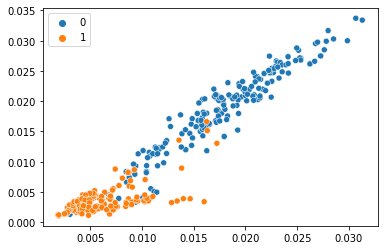

In [26]:
seaborn.scatterplot(x=np.array(hand_gesture.stored_gesture_values)[:,1], 
                    y=np.array(hand_gesture.stored_gesture_values)[:,2], 
                    hue=hand_gesture.stored_gesture_classes)

<AxesSubplot:>

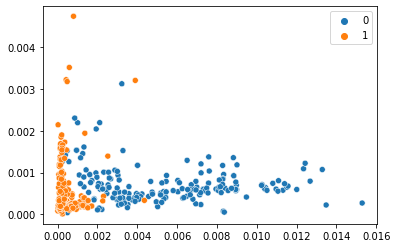

In [28]:
seaborn.scatterplot(x=np.array(hand_gesture.stored_gesture_values)[:,6], 
                    y=np.array(hand_gesture.stored_gesture_values)[:,7], 
                    hue=hand_gesture.stored_gesture_classes)

In [432]:
feature_names = [*[f"f{i}" for i in range(5)], "f4-f0", *[f"f{i}-f{i+1}" for i in range(4)]]
class_names = ["open", "close"]
class_weights = {0:1, 1:2}

In [433]:
visible_features = [5, 6, 7, 8, 9] #[2,5,6,9]#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
feature_names = np.array(feature_names)[visible_features]
X_train, X_test, y_train, y_test = train_test_split(np.array(hand_gesture.stored_gesture_values)[:,visible_features], hand_gesture.stored_gesture_classes, 
                                                    test_size=0.7, random_state=412)

<AxesSubplot:>

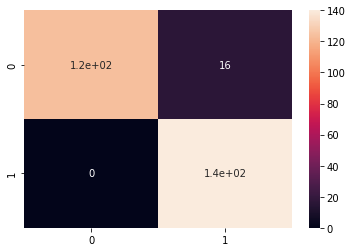

In [434]:
kneighbors_classifier = KNeighborsClassifier(n_neighbors=31)
kneighbors_classifier.fit(X_train, y_train)
kneighbords_y_pred = kneighbors_classifier.predict(X_test)
kneighbors_cm = confusion_matrix(y_true=y_test, y_pred=kneighbords_y_pred)

seaborn.heatmap(kneighbors_cm, annot=True)

<AxesSubplot:>

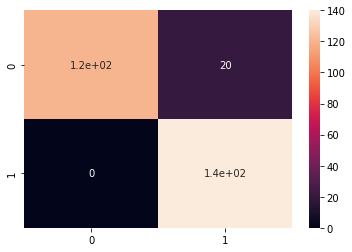

In [446]:
kneighbords_y_pred = kneighbors_classifier.predict_proba(X_test)[:,0] < 2/3
kneighbors_cm = confusion_matrix(y_true=y_test, y_pred=kneighbords_y_pred)

seaborn.heatmap(kneighbors_cm, annot=True)

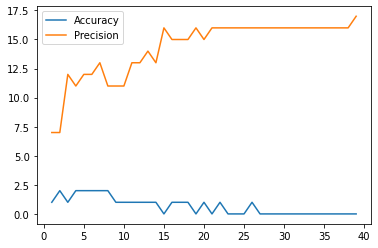

In [436]:
accs = []
precs = []
for n in range(1,40):
    kneighbors_classifier = KNeighborsClassifier(n_neighbors=n)
    kneighbors_classifier.fit(X_train, y_train)
    kneighbords_y_pred = kneighbors_classifier.predict(X_test)
    kneighbors_cm = confusion_matrix(y_true=y_test, y_pred=kneighbords_y_pred)

    acc = kneighbors_cm[1,0]
    accs.append(acc)

    prec = kneighbors_cm[0,1]
    precs.append(prec)

plt.plot(np.arange(1,40), accs)
plt.plot(np.arange(1,40), precs)
plt.legend(["Accuracy","Precision"])
plt.show()

Importance of f4-f0 -> 0.0
Importance of f0-f1 -> 0.0
Importance of f1-f2 -> 0.0
Importance of f2-f3 -> 0.0
Importance of f3-f4 -> 1.0


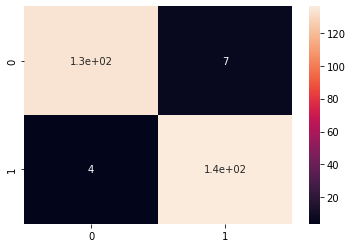

In [437]:
tree_classifier = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight=class_weights)
tree_classifier.fit(X_train, y_train)
tree_y_pred = tree_classifier.predict(X_test)
tree_cm = confusion_matrix(y_true=y_test, y_pred=tree_y_pred)

seaborn.heatmap(tree_cm, annot=True)

for f_name, f_importance in zip(feature_names, tree_classifier.feature_importances_):
    print(f"Importance of {f_name} -> {f_importance}")

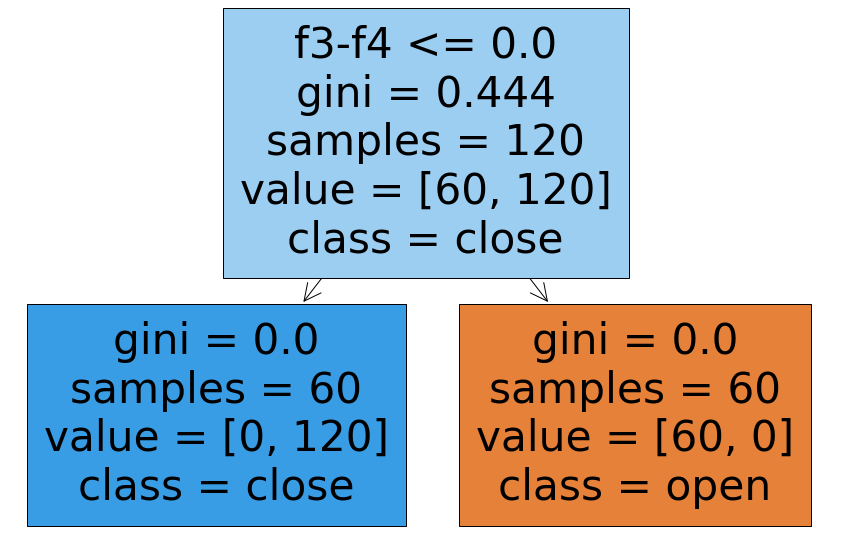

In [438]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(tree_classifier, 
                   feature_names=feature_names,  
                   class_names= class_names,
                   filled=True)

Importance of f4-f0 -> 0.31153548083207255
Importance of f0-f1 -> 0.14111705801935154
Importance of f1-f2 -> 0.003082528541134979
Importance of f2-f3 -> 0.11525602780049019
Importance of f3-f4 -> 0.4290089048069506


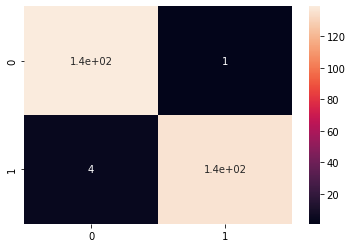

In [439]:
forest_classifier = RandomForestClassifier(max_depth=2, random_state=42, class_weight=class_weights, n_estimators=100)
forest_classifier.fit(X_train, y_train)
forest_y_pred = forest_classifier.predict(X_test)
forest_cm = confusion_matrix(y_true=y_test, y_pred=forest_y_pred)

seaborn.heatmap(forest_cm, annot=True)

for f_name, f_importance in zip(feature_names, forest_classifier.feature_importances_):
    print(f"Importance of {f_name} -> {f_importance}")

array([2, 2])

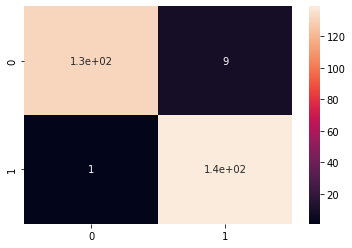

In [440]:
svm_classifier = SVC(kernel="linear", decision_function_shape="ovo", C=1e6, random_state=42, class_weight=class_weights)
svm_classifier.fit(X_train, y_train)
svm_y_pred = svm_classifier.predict(X_test)
svm_cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)

seaborn.heatmap(svm_cm, annot=True)

svm_classifier.n_support_

array([24, 12])

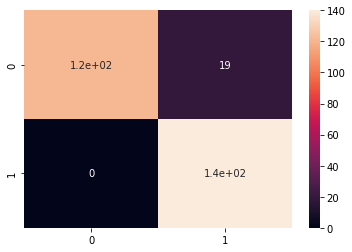

In [441]:
svm_classifier = SVC(kernel="poly", degree=2, decision_function_shape="ovo", C=.1, random_state=42, class_weight=class_weights)
svm_classifier.fit(X_train, y_train)
svm_y_pred = svm_classifier.predict(X_test)
svm_cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)

seaborn.heatmap(svm_cm, annot=True)

svm_classifier.n_support_

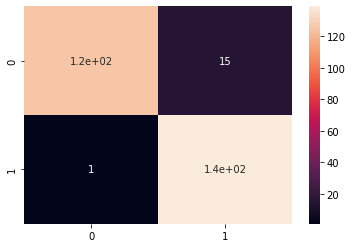

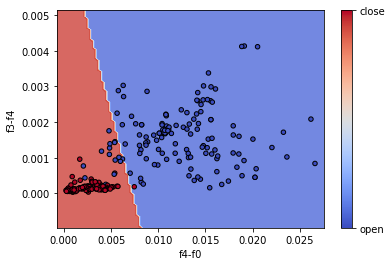

In [444]:
sel_features = [0,4]

svm_classifier = SVC(kernel="poly", degree=1, decision_function_shape="ovo", C=10, random_state=42, class_weight=class_weights)
svm_classifier.fit(X_train[:, sel_features], y_train)
svm_y_pred = svm_classifier.predict(X_test[:, sel_features])
svm_cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)

seaborn.heatmap(svm_cm, annot=True)

fig, ax = plt.subplots()
disp = DecisionBoundaryDisplay.from_estimator(
        svm_classifier,
        X_test[:,sel_features],
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        eps=0.001
    )
scatter = ax.scatter(X_test[:,sel_features[0]], X_test[:,sel_features[1]], c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
ax.set_xlabel(feature_names[sel_features[0]])
ax.set_ylabel(feature_names[sel_features[1]])

cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(len(class_names)))
cbar.set_ticklabels(class_names)

plt.show()